In [1]:
import sys
import os
from pathlib import Path
project_dir = Path(os.path.abspath('')).parent
sys.path.insert(0, project_dir.as_posix())

from tqdm import trange, tqdm
import numpy as np
import torch
from matplotlib import  pyplot as plt
from cs336_basics.nn_336 import TransformerLM
from cs336_basics.train import AdamW, cross_entropy, save_checkpoint, load_checkpoint, load_data, get_lr_cosine_schedule, gradient_clipping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

In [2]:
tokens = np.load(
    project_dir.joinpath("data", "TinyStoriesV2-GPT4-train-encoded.npy"), mmap_mode="r"
)

In [3]:
def train(
    model: TransformerLM,
    optimizer: AdamW,
    epochs,
    batch_size,
    T_w,
    T_c,
    checkpoint_dir=None,
    save_every=50,
):
    losses = optimizer.state["losses"]
    if checkpoint_dir is not None:
        checkpoint_dir = Path(checkpoint_dir)
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
    for _ in trange(epochs):
        epoch = optimizer.state["epoch"] + 1
        optimizer.param_groups[0]["lr"] = get_lr_cosine_schedule(
            epoch,
            (optimizer.state["init_lr"] / 100, optimizer.state["init_lr"]),
            T_w=T_w,
            T_c=T_c,
        )
        x, target = load_data(tokens, batch_size, model.max_seq_len, device=device)
        pred = model(x)
        loss = cross_entropy(pred.view(-1, pred.shape[-1]), target.view(-1))

        optimizer.zero_grad()
        loss.backward()
        # gradient_clipping(model.parameters())
        optimizer.step()

        del x
        del target

        losses.append(loss.item())
        if epoch % save_every == 0:
            if checkpoint_dir is not None:
                save_checkpoint(
                    model,
                    optimizer,
                    epoch,
                    (checkpoint_dir / f"checkpoint_epoch_{epoch}.pt").as_posix(),
                )
            tqdm.write(f"----\nEpoch [{epoch}/{epochs}], Loss: {losses[-1]:.4f}\n")
            fig = plt.figure(figsize=(5, 1.5))
            ax = fig.add_axes(111)
            ax.plot(np.arange(epoch), losses)
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')
            plt.show()

In [4]:
model = TransformerLM(
    vocab_size=10000,
    num_layers=4,
    num_heads=16,
    d_model=512,
    d_ff=1344,
    max_seq_len=256,
    Theta=10000,
    device=device,
)
optimizer = AdamW(
    model.parameters(), lr=0.001, betas=(0.9, 0.95), eps=1e-8, weight_decay=1e-2
)

In [7]:
import pickle
load_checkpoint(project_dir / "checkpoints" / "checkpoint_fast_annealing_128_epoch_3000.pt", model, optimizer)
with open('/home/ztzhu/AI/CS336/assignment1-basics/data/train_bpe_TinyStoriesV2-GPT4-train.pkl', "rb") as f:
    result = pickle.load(f)
vocab = result["vocab"]

for seed in [5, 6]:
    np.random.seed(5)
    torch.manual_seed(seed)
    x, target = load_data(tokens, 1, 50, device=device)
    x = x[0]
    target = target[0]
    target = ''.join([vocab[i].decode() for i in target.detach().cpu().numpy()])
    result = model.decode(x, vocab, max_token_num=100)
    if seed == 5:
        print(f"target:\n{target}")
    print(f"-----\nsequel:\n{result}")

 91%|█████████ | 91/100 [00:00<00:00, 371.42it/s]


target:
 mud pies with his hands. One day, Tim saw his mom wash her hands with soap and water. He thought it was fun and wanted to try it too.
Tim went inside and found an empty sink. He turned on the water and put
-----
sequel:
 saw a big, shiny rock. Tim was very happy and said, "Wow, this rock is so pretty!" He wanted to show his mom the rock.
Tim went outside and saw his friend, Sue. Sue was playing with her toy car. Tim said, "Sue, let's play with the rock!" Sue smiled and said, "Yes, let's play together!" They played with the rock all day and had lots of fun.
<|endoftext|>


100%|██████████| 100/100 [00:00<00:00, 389.42it/s]


-----
sequel:
 saw a big, shiny rock. He thought it was a fun toy, so he put it in his mouth. He put the rock in the water and waited for it to dry.
But then, something unexpected happened. The rock started to move! It was not a rock at all! It was a big, friendly bear! The bear said, "Hello, Tim! I am a magic bear. I can help you make your toys come to life!" Tim was very surprised. He had


  4%|▍         | 199/5000 [03:14<1:20:37,  1.01s/it]

----
Epoch [200/5000], Loss: 4.0063



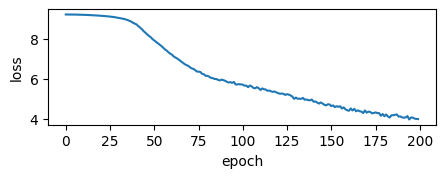

  8%|▊         | 399/5000 [06:40<1:19:20,  1.03s/it]

----
Epoch [400/5000], Loss: 3.1188



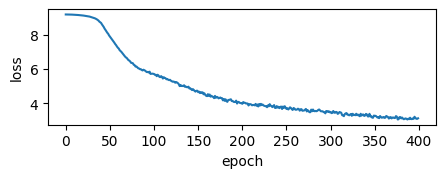

 12%|█▏        | 599/5000 [10:08<1:16:06,  1.04s/it]

----
Epoch [600/5000], Loss: 2.6065



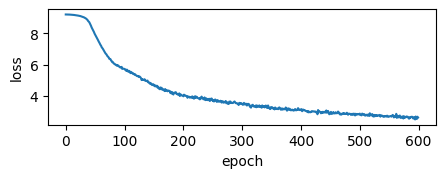

 16%|█▌        | 799/5000 [13:36<1:12:52,  1.04s/it]

----
Epoch [800/5000], Loss: 2.3601



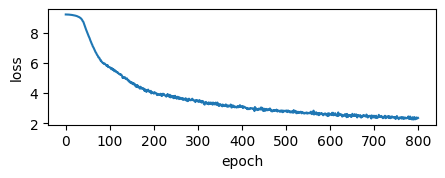

 20%|█▉        | 999/5000 [17:04<1:09:20,  1.04s/it]

----
Epoch [1000/5000], Loss: 2.1473



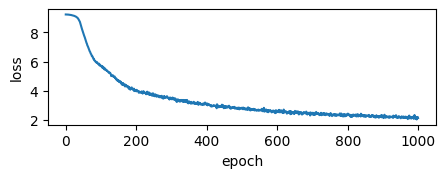

 24%|██▍       | 1199/5000 [20:33<1:05:51,  1.04s/it]

----
Epoch [1200/5000], Loss: 2.0492



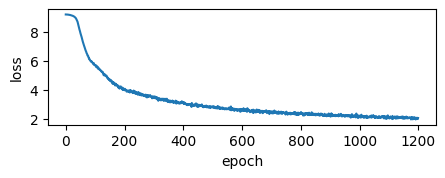

 28%|██▊       | 1399/5000 [24:01<1:02:32,  1.04s/it]

----
Epoch [1400/5000], Loss: 2.0386



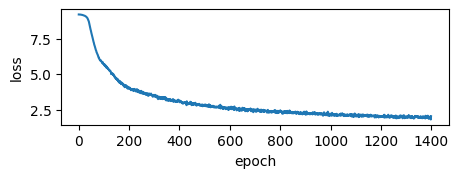

 32%|███▏      | 1599/5000 [27:30<59:06,  1.04s/it]  

----
Epoch [1600/5000], Loss: 1.8996



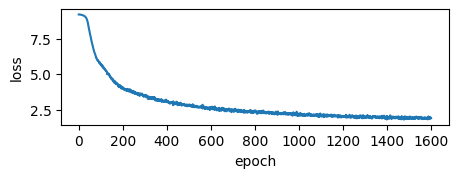

 36%|███▌      | 1799/5000 [30:59<55:35,  1.04s/it]  

----
Epoch [1800/5000], Loss: 1.9155



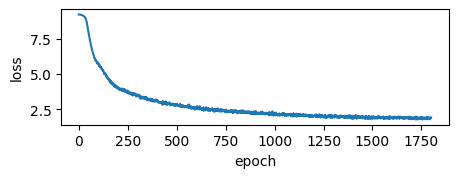

 40%|███▉      | 1999/5000 [34:28<52:09,  1.04s/it]  

----
Epoch [2000/5000], Loss: 1.8935



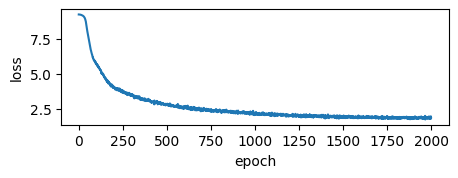

 44%|████▍     | 2199/5000 [37:57<48:47,  1.05s/it]

----
Epoch [2200/5000], Loss: 1.7829



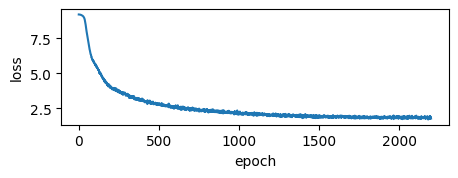

 48%|████▊     | 2399/5000 [41:26<45:16,  1.04s/it]

----
Epoch [2400/5000], Loss: 1.8291



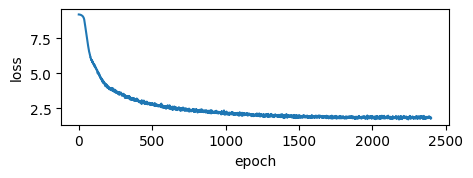

 52%|█████▏    | 2599/5000 [44:55<41:48,  1.04s/it]

----
Epoch [2600/5000], Loss: 1.7991



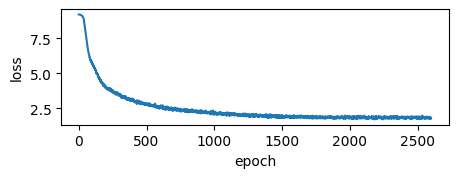

 56%|█████▌    | 2799/5000 [48:24<38:17,  1.04s/it]

----
Epoch [2800/5000], Loss: 1.8236



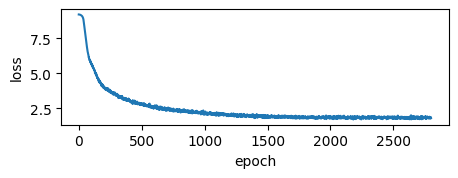

 60%|█████▉    | 2999/5000 [51:53<34:52,  1.05s/it]

----
Epoch [3000/5000], Loss: 1.8201



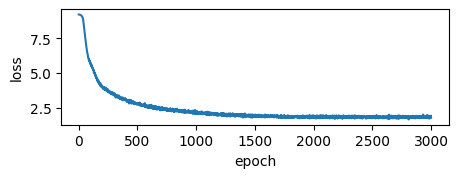

 62%|██████▏   | 3102/5000 [53:41<32:51,  1.04s/it]


KeyboardInterrupt: 

In [5]:
train(
    model,
    optimizer,
    epochs=5000,
    batch_size=64,
    T_w=500,
    T_c=2000,
    checkpoint_dir=project_dir / "checkpoints_fast",
    save_every=200,
)